# Generate Questions With GPT 3.5

In [391]:
import os
import json
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import openai

## Load the 200 Kaggle examples

In [2]:
df_test = pl.read_csv('data/train.csv')
df_test = df_test.drop(columns="id")
print(f'{df_test.shape[0]:,}')
df_test[:3]

200


prompt,A,B,C,D,E,answer
str,str,str,str,str,str,str
"""Which of the f…","""MOND is a theo…","""MOND is a theo…","""MOND is a theo…","""MOND is a theo…","""MOND is a theo…","""D"""
"""Which of the f…","""Dynamic scalin…","""Dynamic scalin…","""Dynamic scalin…","""Dynamic scalin…","""Dynamic scalin…","""A"""
"""Which of the f…","""The triskeles …","""The triskeles …","""The triskeles …","""The triskeles …","""The triskeles …","""A"""


In [339]:
options = ['A', 'B', 'C', 'D', 'E']
long_test = df_test.melt(['prompt', 'answer'], options, variable_name='option')
long_test = long_test.with_columns(long_test['value'].str.lengths().alias('answer_length'))
long_test[:4]

prompt,answer,option,value,answer_length
str,str,str,str,u32
"""Which of the f…","""D""","""A""","""MOND is a theo…",164
"""Which of the f…","""A""","""A""","""Dynamic scalin…",285
"""Which of the f…","""A""","""A""","""The triskeles …",323
"""What is the si…","""C""","""A""","""Regularizing t…",221


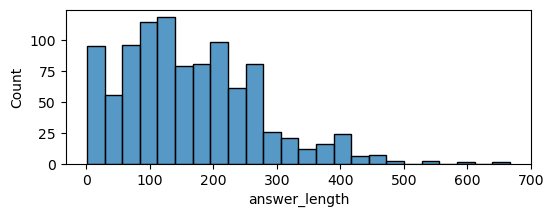

In [340]:
plt.figure(figsize=(6,2))
sns.histplot(long_test, x='answer_length');

## Load the Wikipedia data

In [189]:
pages = pl.read_parquet('./data/wiki_with_category.parquet')
print(f'{pages.shape[0]:,}')
pages.columns

153,750


['title',
 'category',
 'page_id',
 'parent_id',
 'revision_id',
 'revision_ts',
 'short_description',
 'sha1',
 'page_bytes',
 'section_index',
 'section_title',
 'section_level',
 'section_text']

/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/transforms.py:2041: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/transforms.py:383: RuntimeWarning: invalid value encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


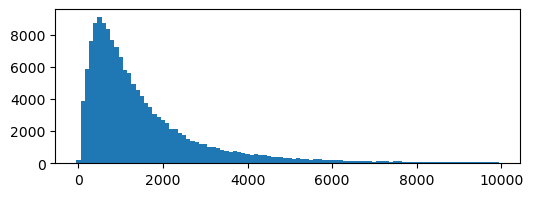

0.05: 167
0.25: 534
0.50: 1,047
0.66: 1,556
0.75: 2,001
0.90: 3,679
0.95: 5,414
0.99: 11,650


In [6]:
pages = pages.with_columns(pages['section_text'].str.lengths().alias('length'))
hist_output = pages['length'].hist(bins=range(0, 10000, 100))
bin_edges = hist_output['break_point']
counts = hist_output['length_count']

plt.subplots(figsize=(6,2))
plt.bar(bin_edges, counts, width=(bin_edges[1] - bin_edges[0]))
plt.show()

for p in [0.05, 0.25, 0.5, 0.66, 0.75, 0.9, 0.95, 0.99]:
    print(f"{p:.2f}: {pages['length'].quantile(p):,.0f}")

In [65]:
summaries = pages.filter(pl.col('section_title') == 'Summary')
summaries = summaries[['page_id', 'section_text']]
summaries = summaries.rename({'section_text':'summary'})
non_summaries = pages.filter(pl.col('section_title') != 'Summary')
with_sum = non_summaries.join(summaries, how='left', on='page_id')

In [399]:
sample_size = 10
sample = with_sum[['title', 'section_title', 'length', 'summary', 'section_text']].sample(sample_size)
sample = sample.with_columns(pl.when(cs.string().str.lengths() >= 4000)\
                               .then('[*] ' + cs.string().str.slice(0, 4000))\
                               .otherwise(cs.string())\
                               .keep_name())
#with pl.Config(fmt_str_lengths=5000):
#    display(sample[:3])
sample.columns

['title', 'section_title', 'length', 'summary', 'section_text']

In [400]:
sample_questions = df_test.sample(sample_size)
all_new_rows = []
for row in sample_questions.iter_rows(named=True):
    incorrect = []
    for letter in options:
        if letter == row['answer']:
            correct = row[letter]
        else:
            incorrect.append(row[letter])
    
    new_row = {'prompt': row['prompt'], 'correct': correct}
    for i in range(4):
        new_row[f'incorrect_{i+1}'] = incorrect[i]
    all_new_rows.append(new_row)

    
sample_questions = pl.DataFrame(all_new_rows)
# with pl.Config(fmt_str_lengths=5000):
#     display(sample_questions)

In [401]:
def wiki_section_to_prompt(section_row, question_row):
    return f'''
You are a psychometrics researcher designing a test to check the reasoning abilities of graduate students in STEM fields. 
Create a difficult to answer multiple choice question from the Wikipedia snippet below, with 6 options which are 
concise, complex and ideally more than 200 charachters long. Provide only one correct option. The options should include only one correct statement and the other statements should be incorrect.
A partial response that is missing an aspect is not incorrect. All but one statement need to incluse a false assertion. Make sure there are also incorrect answers that are longer than the correct answer.
Example:
{{
    "question": "{question_row['prompt']}",
    "correct": "{question_row['correct']}",
    "incorrect_1": "{question_row['incorrect_1']}",
    "incorrect_2": "{question_row['incorrect_2']}",
    "incorrect_3": "{question_row['incorrect_3']}",
    "incorrect_4": "{question_row['incorrect_4']}",
    "incorrect_5": "gibberish + {question_row['incorrect_4']}"
}}

Use the following section of an Wikipedia article to inspire the question. In case the section is too specific, below there is also the summary of the page. 

Section: {section_row['title']}
{section_row['summary']}

Summary of: {section_row['section_title']}
{section_row['section_text']}
'''

In [402]:
mc5_schema = {
  "name": "mc5_dummy_function",
  "parameters": {
      "description": "A multiple choice question with 6 possible answers A-E and a field denoting the correct answer.",
      "type": "object",
      "properties": {
        "question": {},
        "correct": {},
        "incorrect_1": {},
        "incorrect_2": {},
        "incorrect_3": {},
        "incorrect_4": {},
        "incorrect_5": {}
      },
      "required": ["question", "correct",  "incorrect_1", "incorrect_2", "incorrect_3", "incorrect_4"]
    }
}

In [403]:
openai.api_key = os.environ['OPENAI_API_KEY']
def ask_chat_gpt(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=[
            {"role": "user", "content": f"{prompt}"}
        ],
        functions = [mc5_schema],
        function_call = {
            "name": "mc5_dummy_function"
        },
        max_tokens=1500
    )
    response_message = response["choices"][0]["message"]
    return response_message['function_call']['arguments']

In [404]:
all_prompts = []
questions = []
for section_row, question_row in zip(sample.iter_rows(named=True), sample_questions.iter_rows(named=True)):
    print(section_row['title'], section_row['section_title'])
    prompt = wiki_section_to_prompt(section_row, question_row)
    all_prompts.append(prompt)
    questions.append(ask_chat_gpt(prompt))

Stellar corona Flares
Quantum spacetime Models
Kármán line Interpretations of the definition
Cuticle Botany
Squeezed coherent state Operator representation
Lead Bulk
Turner syndrome Inheritance
Complex random variable Variance and pseudo-variance
Wirtinger derivatives Historical references
Binding site Binding curves


In [405]:
df_q = pl.from_dicts([json.loads(q_str) for q_str in questions])
df_q = df_q.with_columns(sample['title'], sample['section_title'])
df_q.write_parquet('./data/daniel_train_aug_17.parquet')

In [406]:
with pl.Config(fmt_str_lengths=2000):
    display(df_q)

question,correct,incorrect_1,incorrect_2,incorrect_3,incorrect_4,incorrect_5,title,section_title
str,str,str,str,str,str,str,str,str
"""What is the corona?""","""The corona is the outermost layer of a star's stellar atmosphere consisting of plasma.""","""The corona is the innermost layer of a star's stellar atmosphere consisting of solid matter.""","""The corona is the middle layer of a star's stellar atmosphere consisting of liquid matter.""","""The corona is the outermost layer of a star's stellar atmosphere consisting of gas.""","""The corona is the middle layer of a star's stellar atmosphere consisting of plasma.""",null,"""Stellar corona""","""Flares"""
"""Which of the following statements is true about quantum spacetime?""","""Quantum spacetime is a generalization of the usual concept of spacetime where some variables do not commute and form a different Lie algebra.""","""Quantum spacetime is a theory that combines quantum mechanics and general relativity to describe the behavior of spacetime.""","""Quantum spacetime is a mathematical theory that deals with the discrete nature of spacetime.""","""Quantum spacetime is a concept in which spacetime is quantized into small, indivisible units.""","""Quantum spacetime is a theory that proposes the existence of extra dimensions beyond the three spatial dimensions and one temporal dimension.""","""Quantum spacetime is a model that explains the behavior of particles and fields at extremely small scales.""","""Quantum spacetime""","""Models"""
"""What is the Kármán line?""","""The Kármán line is a proposed conventional boundary between Earth's atmosphere and outer space set by the international record-keeping body Fédération Aéronautique Internationale at an altitude of 100 km (62 mi) above mean sea level.""","""The Kármán line is a theoretical limit of altitude for airplane flight calculated by Theodore von Kármán in 1957.""","""The Kármán line is a region below the boundary of Outer Space that includes substantially lower regions as well, often referred to as the 'edge of space'.""","""The Kármán line is the altitude reachable by a conventional airplane or a high-altitude balloon, well above the conventional flight altitudes.""","""The Kármán line is an international legal definition of the demarcation between a country's air space and outer space.""","""The Kármán line is a physical boundary in the atmosphere where there is a noticeable change in its characteristics, marking the transition to outer space.""","""Kármán line""","""Interpretations of the definition"""
"""What is the purpose of plant cuticles?""","""Plant cuticles function as permeability barriers for water and water-soluble materials. They prevent plant surfaces from becoming wetting and also help to prevent plants from drying out.""","""Plant cuticles function as absorbent layers, allowing plants to take in more water and nutrients.""","""Plant cuticles function as protective shields, shielding the plant from physical damage and predators.""","""Plant cuticles function as conduits for the movement of nutrients and water between plant tissues.""","""Plant cuticles function as sensors, detecting changes in environmental conditions and triggering response mechanisms.""",null,"""Cuticle""","""Botany"""
"""According to the Wikipedia snippet, what is a squeezed coherent state?""","""A squeezed coherent state is a quantum state that has reduced uncertainty in one of its quadrature components and increased uncertainty in the other.""","""A squeezed coherent state is a quantum state that has equal uncertainty in both of its quadrature components.""","""A squeezed coherent state is a quantum state that has increased uncertainty in both of its quadrature components.""","""A squeezed coherent state is a quantum state that has reduced uncertainty in both of its quadrature components.""","""A squeezed coherent state is a quantum state that has reduced uncertainty in one of its quadrature components and equal uncertainty in the

{
    "question": "What is the difference between a countably-additive vector measure and a non-countably-additive vector measure?",
    "correct": "A countably-additive vector measure assigns a value to countable unions of sets, while a non-countably-additive vector measure does not.",
    "incorrect_1": "A countably-additive vector measure assigns a value to finite unions of sets, while a non-countably-additive vector measure does not.",
    "incorrect_2": "A countably-additive vector measure assigns a value to all sets, while a non-countably-additive vector measure assigns a value only to certain sets.",
    "incorrect_3": "A countably-additive vector measure assigns a value to countable intersections of sets, while a non-countably-additive vector measure does not.",
    "incorrect_4": "A countably-additive vector measure assigns a value to infinite unions of sets, while a non-countably-additive vector measure does not."
}



You are a psychometrics researcher designing a test to check the reasoning abilities of graduate students in STEM fields. 
Create a difficult to answer multiple choice question from the Wikipedia snippet below, with 5 options which are 
concise, complex and ideally more than 200 charachters long. Provide only one correct option. The options should include only one correct statement and the other statements should be incorrect.
A partial response that is missing an aspect is not incorrect. All but one statement need to incluse a false assertion.
Example:
{
    "question": "What is the relationship between the Cauchy momentum equation and the Navier-Stokes equation?",
    "correct": "The Navier-Stokes equation can be derived from the Cauchy momentum equation by specifying the stress tensor through a constitutive relation, expressing the shear tensor in terms of viscosity and fluid velocity, and assuming constant density and viscosity.",
    "incorrect_1": "The Navier-Stokes equation is 